In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt

In [2]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            #Input = Nxchannels_imgx64x64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            self._block(features_d, features_d*2, 4, 2, 1), #Nxfeatures_d*2x32x32
            self._block(features_d*2, features_d*4, 4, 2, 1), #Nxfeatures_d*4x16x16
            self._block(features_d*4, features_d*8, 4, 2, 1), #Nxfeatures_d*8x8x8
            self._block(features_d*8, features_d*16, 4, 2, 1), #Nxfeatures_d*16x4x4

            nn.Conv2d(features_d*16, 1, kernel_size=4, stride=2, padding=1), #Nx1x4x4
            ## Note: No sigmoid here
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False,),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.critic(x)
    
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            #Input = N*z_dim*1*1
            self._block(z_dim, features_g*16, 4, 1, 0), #N*features_g*16*4*4
            self._block(features_g*16, features_g*8, 4, 2, 1), #N*features_g*8*8*8
            self._block(features_g*8, features_g*4, 4, 2, 1), #N*features_g*4*16*16
            self._block(features_g*4, features_g*2, 4, 2, 1), #N*features_g*2*32*32
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1), #N*channels_img*64*64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False,),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.gen(x)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m , (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lr = 1e-4 #vary 
z_dim = 100 #vary
img_dim = 64
channels_img = 1
batch_size = 64
num_epochs = 30
features_d = 64
features_g = 64

critic_iter = 5
weight_clip = 0.02

In [4]:
transformation = transforms.Compose(
    [
        transforms.Resize(img_dim),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)]),     
    ]
) 

dataset = datasets.MNIST(root = "dataset", transform = transformation, download = True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [5]:
critic = Critic(channels_img, features_d).to(device)
gen = Generator(z_dim, channels_img, features_g).to(device)

initialize_weights(critic)
initialize_weights(gen)

opt_critic = optim.RMSprop(critic.parameters(), lr = lr)
opt_gen = optim.RMSprop(gen.parameters(), lr = lr)

In [6]:
fixed_noise = torch.randn((32, z_dim, 1, 1)).to(device)

In [7]:
def show(imgs): #Show function from pytorch.org
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Epoch [0/30] Batch 0/938 \Loss Critic: -0.9148, loss Generator: 0.5029
Epoch [1/30] Batch 0/938 \Loss Critic: -3.1660, loss Generator: 1.5641
Epoch [2/30] Batch 0/938 \Loss Critic: -3.1663, loss Generator: 1.5642
Epoch [3/30] Batch 0/938 \Loss Critic: -3.1666, loss Generator: 1.5644
Epoch [4/30] Batch 0/938 \Loss Critic: -3.1656, loss Generator: 1.5637
Epoch [5/30] Batch 0/938 \Loss Critic: -3.1662, loss Generator: 1.5643
Epoch [6/30] Batch 0/938 \Loss Critic: -3.1646, loss Generator: 1.5639
Epoch [7/30] Batch 0/938 \Loss Critic: -3.1319, loss Generator: 1.5478
Epoch [8/30] Batch 0/938 \Loss Critic: -3.1537, loss Generator: 1.5579
Epoch [9/30] Batch 0/938 \Loss Critic: -3.1578, loss Generator: 1.5602
Epoch [10/30] Batch 0/938 \Loss Critic: -0.0948, loss Generator: -0.8298
Epoch [11/30] Batch 0/938 \Loss Critic: -3.1579, loss Generator: 1.5599
Epoch [12/30] Batch 0/938 \Loss Critic: -3.1609, loss Generator: 1.5616
Epoch [13/30] Batch 0/938 \Loss Critic: -3.1433, loss Generator: 1.5551
E

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


Epoch [21/30] Batch 0/938 \Loss Critic: -3.1649, loss Generator: 1.5639
Epoch [22/30] Batch 0/938 \Loss Critic: -0.1852, loss Generator: -1.2760
Epoch [23/30] Batch 0/938 \Loss Critic: -3.1650, loss Generator: 1.5619
Epoch [24/30] Batch 0/938 \Loss Critic: -3.1437, loss Generator: 1.5549
Epoch [25/30] Batch 0/938 \Loss Critic: -3.1638, loss Generator: 1.5632
Epoch [26/30] Batch 0/938 \Loss Critic: -3.1644, loss Generator: 1.5636
Epoch [27/30] Batch 0/938 \Loss Critic: -3.1478, loss Generator: 1.5546
Epoch [28/30] Batch 0/938 \Loss Critic: -2.6761, loss Generator: 1.5186
Epoch [29/30] Batch 0/938 \Loss Critic: -3.1640, loss Generator: 1.5627


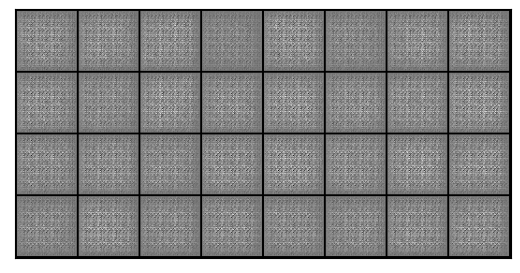

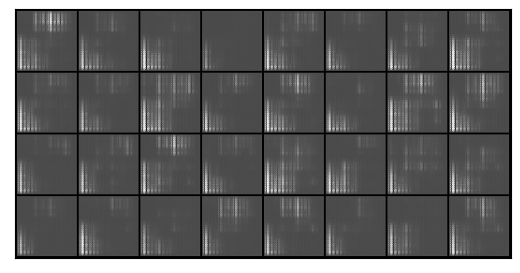

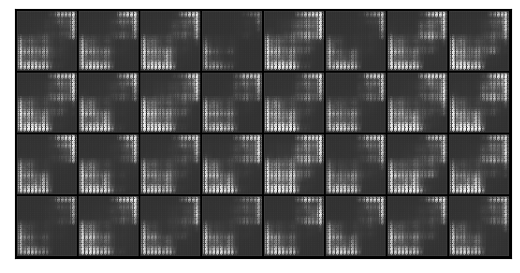

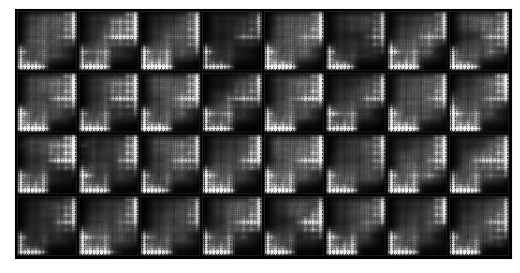

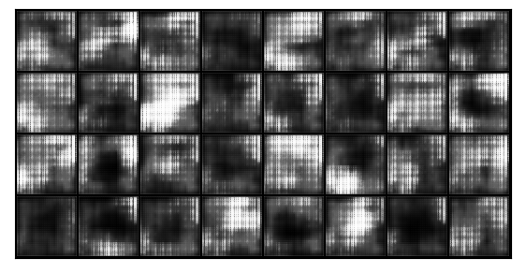

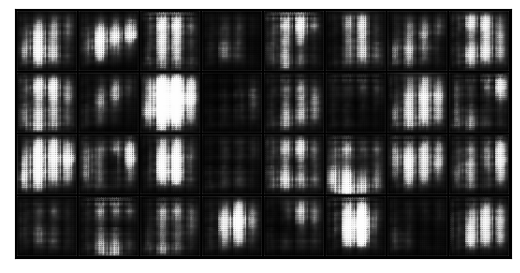

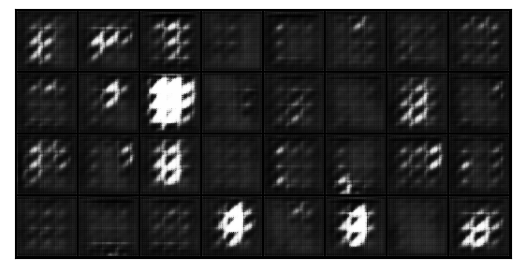

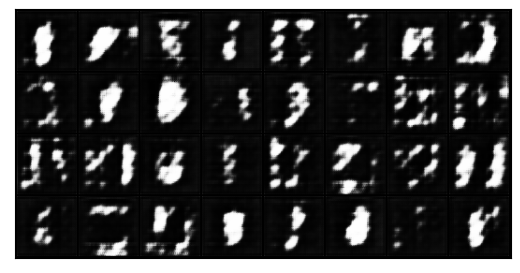

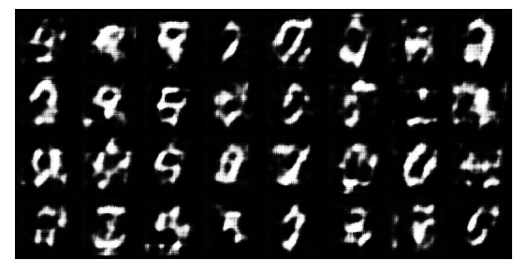

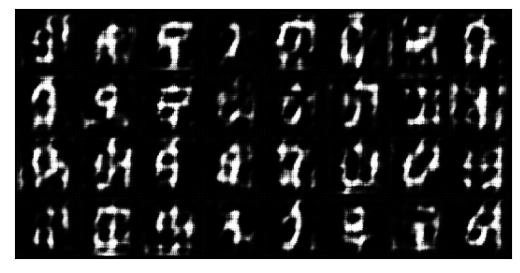

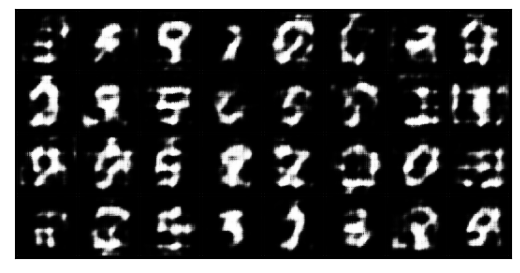

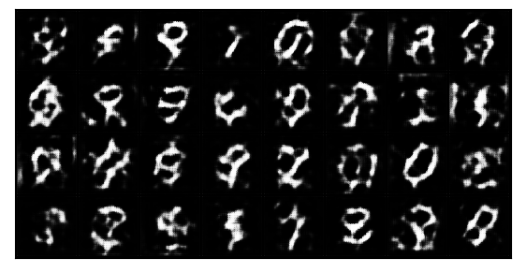

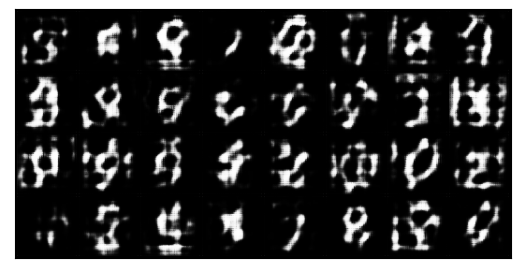

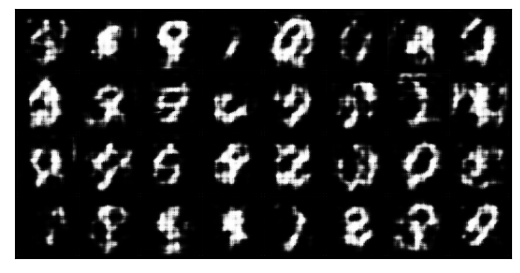

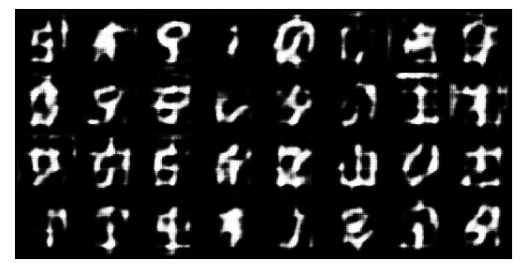

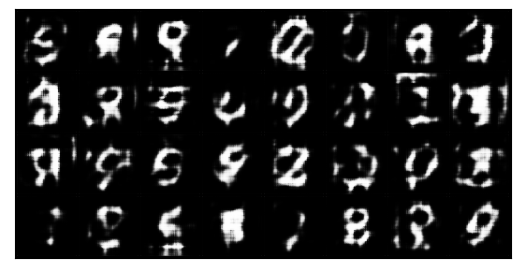

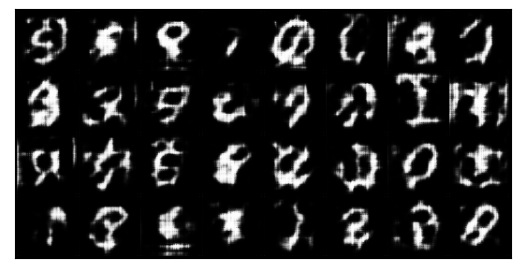

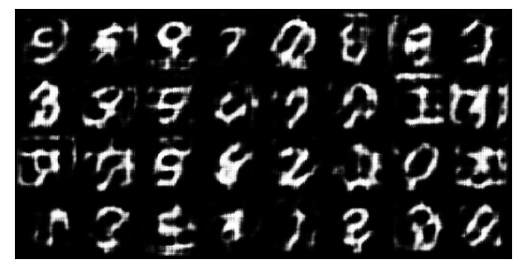

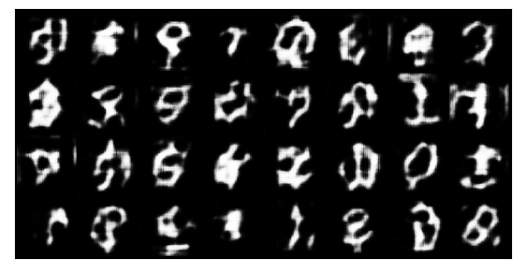

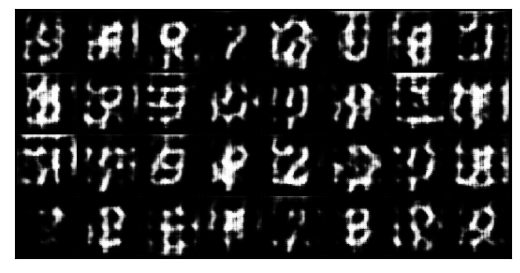

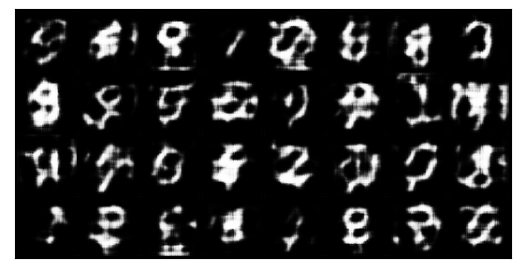

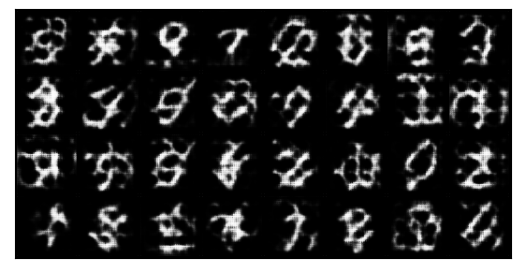

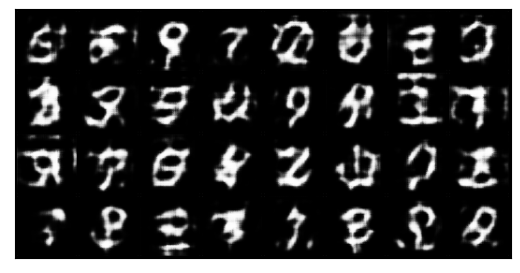

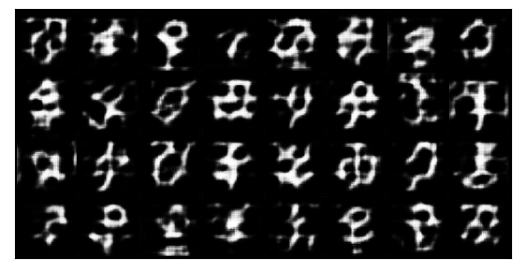

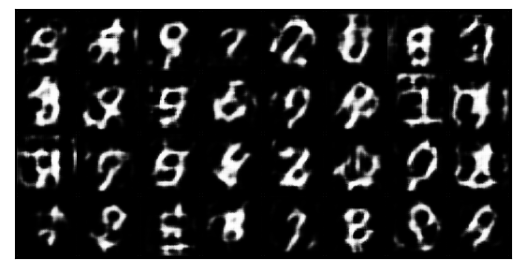

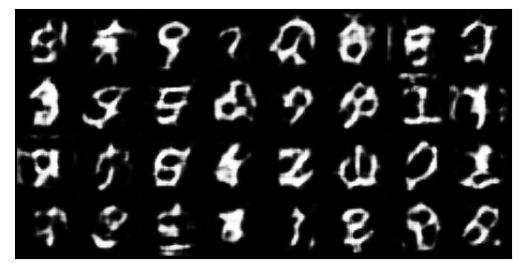

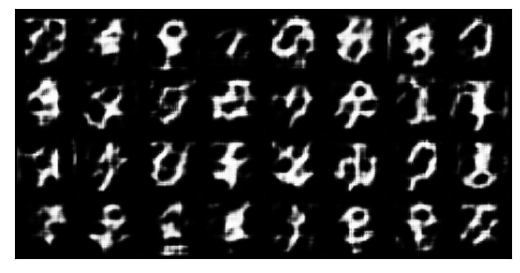

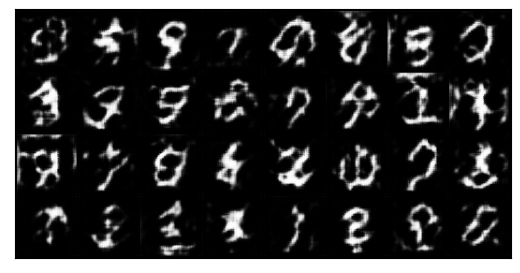

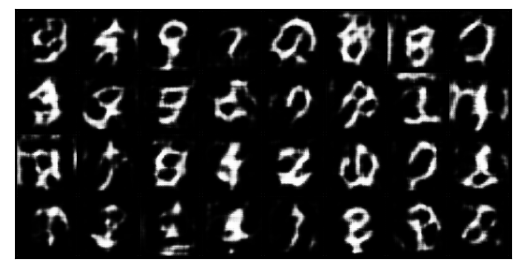

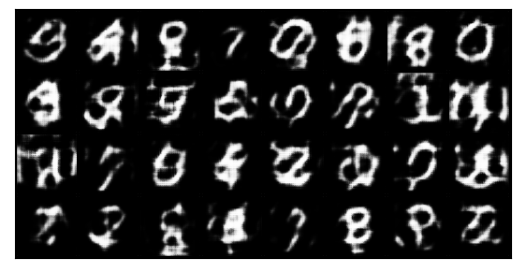

In [8]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        batch_size = real.shape[0]
        
        # Train Critic Max E[critic(real)] - E[critic(fake)]
        for _ in range(critic_iter):
            noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
            fake = gen(noise)

            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

            critic.zero_grad()
            loss_critic.backward(retain_graph = True)# a
            opt_critic.step()

            for para in critic.parameters():
                para.data.clamp_(-weight_clip, weight_clip)

        # Train Gen Min -E[critic(fake)]

        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)

        gen.zero_grad()
        loss_gen.backward(retain_graph = True)# a
        opt_gen.step()


###################################################
        if (batch_idx == 0):
            print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \Loss Critic: {loss_critic:.4f}, loss Generator: {loss_gen:.4f}")

            if (batch_idx == 0):
                with torch.no_grad():
                    fake = gen(fixed_noise).reshape(-1, channels_img, img_dim, img_dim)
                    img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                    show(img_grid_fake)
####################################################